In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
vero = pd.read_csv('verodata.csv', index_col=0)
records = pd.read_csv('records_processed.csv', index_col=0)

vero['Kunta'] = vero.Verotuskunta.str[:3].str.strip().fillna(vero.Verotuskunta).astype(int)
pienet = vero.Kunta.value_counts().index[vero.Kunta.value_counts() < 7446].values
vero.loc[vero.Kunta.isin(pienet),'Kunta'] = 0

vero['Oy'] = (vero['Verovelvollisen nimi'].str.contains(' Ab') | \
vero['Verovelvollisen nimi'].str.contains(' Oy')).astype(int)
vero.drop(['Verovelvollisen nimi', 'Verotuskunta'], 1, inplace=True)

records = pd.get_dummies(records, columns=['typeOfRegistration'])
records.drop(['entryCodes', 'registrationDate'], 1, inplace=True)
records['Verovuosi'] = records.index.str[:4].astype(int)
records = records.groupby(['businessId', 'Verovuosi']).sum().reset_index()

vero = pd.merge(vero, records, how='left', left_on=['Y-tunnus', 'Verovuosi'],
         right_on=['businessId', 'Verovuosi']).fillna(0).drop('businessId', 1)


vero['Muutokset'] = vero.iloc[:,8:-11].sum(1)
vero['Tyypit'] = vero.iloc[:,-12:-1].sum(1)

C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\lauri\AppData\Local\Continuum\anaconda3\envs\kerasenv\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Predictive modelling

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
import featuretools as ft
from sklearn.metrics import log_loss

In [4]:
X = vero.loc[:,['Y-tunnus', 'Verovuosi', 'Verotettava tulo', 'Maksuunpannut verot yhteensä',
       'Ennakot yhteensä', 'Veronpalautus', 'Jäännösvero', 'Oy', 'Muutokset', 'Tyypit']]
features = X.columns[1:]
for col in features:
    for col2 in features:
        X[col+'*'+col2] = (X[col2] * X[col])
for col in features:
    for col2 in features:
        X[col+'/'+col2] = (X[col2] / X[col])

In [5]:
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

X_agg = X.groupby('Y-tunnus').agg(['mean', 'last'])
X_agg.columns = [' '.join(col) for col in X_agg.columns]

In [6]:
protests = pd.read_csv('protestit2.csv', index_col=0).set_index('0')
y = (X_agg.index.isin(protests[pd.to_datetime(protests['3']) > '2019-03-11'].index)).astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_agg, y, stratify=y, random_state=42)
kfold = StratifiedKFold()

#### Logistic regression with original set of features

In [85]:
clf = LogisticRegression(solver='liblinear', penalty='l1', C=0.01)
pipe = Pipeline([('sclr', StandardScaler()), ('logreg', clf)])
pipe.fit(X_train.loc[:,features], y_train)
print('Acc on train data: ', pipe.score(X_train.loc[:,features], y_train))
print('Acc on test data: ', pipe.score(X_test.loc[:,features], y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, pipe.predict_proba(X_train.loc[:,features])))
print('Log loss on test: ', log_loss(y_test, pipe.predict_proba(X_test.loc[:,features])))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9736927136625558
Acc on test data:  0.9736860705811077
Training benchmark:  0.9736994453120793 
Test benchmark:  0.9736994453120793
Log loss on train:  0.1173112858101589
Log loss on test:  0.11804251842503324
Training benchmark:  0.12163738658734163 
Test benchmark:  0.12164922256405906


#### Logistic regression with set of engineered features

In [86]:
logreg = LogisticRegression(solver='liblinear', penalty='l1', C=0.01)
log_pipe = Pipeline([('sclr', StandardScaler()), ('clf', logreg)])
log_pipe.fit(X_train, y_train)
print('Acc on train data: ', log_pipe.score(X_train, y_train))
print('Acc on test data: ', log_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, log_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, log_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9736758845387474
Acc on test data:  0.9736153884990155
Training benchmark:  0.9736994453120793 
Test benchmark:  0.9736994453120793
Log loss on train:  0.10620652167836919
Log loss on test:  0.10698159937392374
Training benchmark:  0.12163738658734163 
Test benchmark:  0.12164922256405906


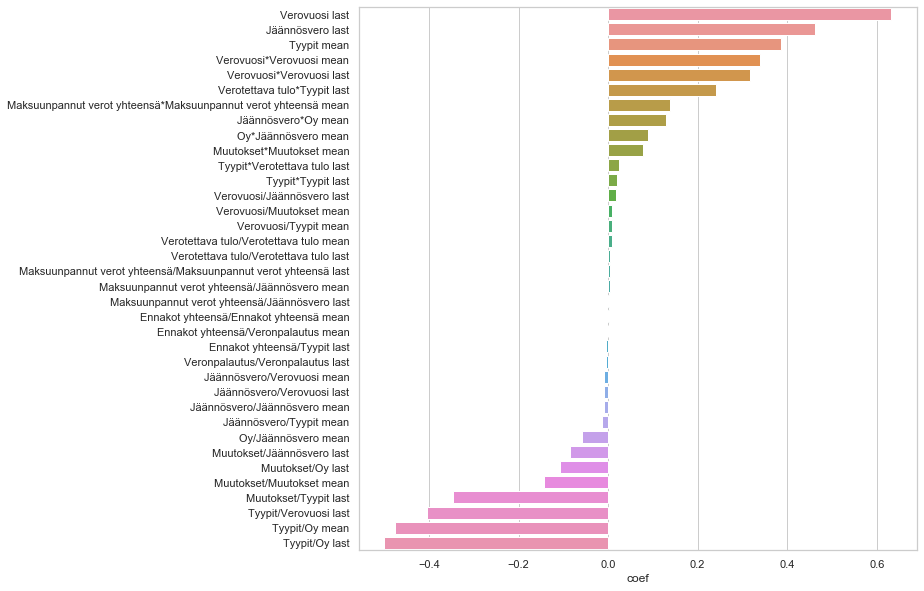

In [117]:
coef = log_pipe['clf'].coef_[0]
coef = pd.DataFrame(coef[coef != 0], index=X_agg.columns[coef != 0], columns=['coef'])
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef.sort_values('coef', ascending=False))

In [118]:
params={
    'subsample': 0.9,
    'validation_fraction': 0.1, 
    'n_iter_no_change': 10,
    'learning_rate': 0.08,
    'n_estimators': 10000,
    'max_depth': 4
}
gbc = GradientBoostingClassifier(**params)
gb_pipe = Pipeline([('sclr', StandardScaler()), ('clf', gbc)])
gb_pipe.fit(X_train, y_train)
print('Acc on train data: ', gb_pipe.score(X_train, y_train))
print('Acc on test data: ', gb_pipe.score(X_test, y_test))
print('Training benchmark: ', 1-y_train.mean(), '\nTest benchmark: ', 1-y_train.mean())
print('Log loss on train: ', log_loss(y_train, gb_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, gb_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

Acc on train data:  0.9739956378911089
Acc on test data:  0.9733831473721412
Training benchmark:  0.9736994453120793 
Test benchmark:  0.9736994453120793
Log loss on train:  0.08985243919104144
Log loss on test:  0.09271886013835809
Training benchmark:  0.12163738658734163 
Test benchmark:  0.12164922256405906


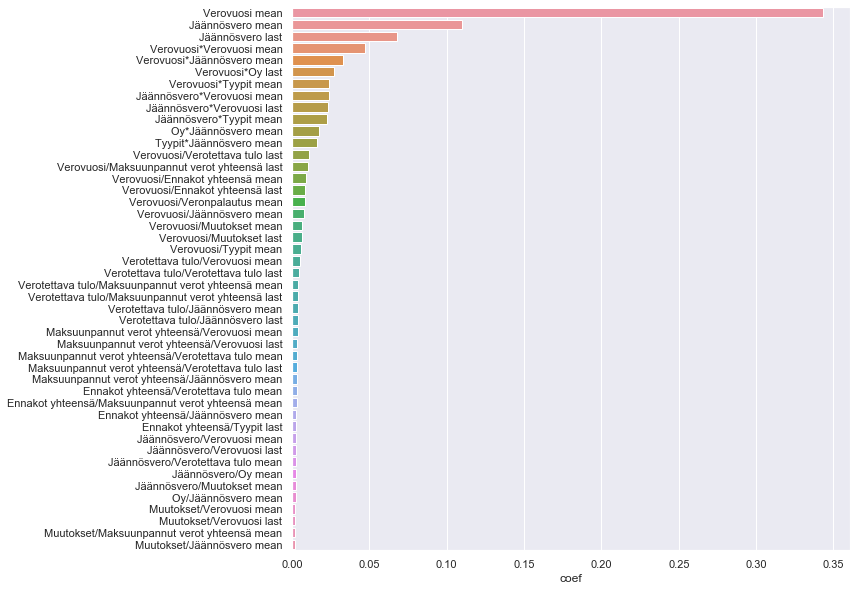

In [125]:
coef = gb_pipe['clf'].feature_importances_
coef = pd.DataFrame(coef[coef > 0.002], index=X_agg.columns[coef > 0.002], columns=['coef'])
f, ax = plt.subplots(figsize=(10, 10))
sns.set(style='darkgrid')
sns.barplot(x='coef', y=coef.index, data=coef.sort_values('coef', ascending=False))


### Deep learning model

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [43]:
n_cols = X_agg.shape[1]
input_shape = (n_cols,)

def create_model():
    # Specify the model
    model = Sequential()
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(n_cols, input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/2), input_shape = input_shape, activation='sigmoid'))
    model.add(Dense(int(n_cols/4), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(optimizer=Adam(lr=0.002), loss='binary_crossentropy')
    return model

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=5)

nnc = KerasClassifier(build_fn=create_model, epochs=160, verbose=1)

In [ ]:
nn_pipe = Pipeline([('sclr', MinMaxScaler()), ('clf', nnc)])
history = nn_pipe.fit(X_train, y_train, clf__validation_split=0.1, clf__restore_best_weights=True)

Train on 267393 samples, validate on 29711 samples
Epoch 1/160
267393/267393 [==============================] - 52s 194us/step - loss: 0.1109 - val_loss: 0.1051
Epoch 2/160
267393/267393 [==============================] - 50s 186us/step - loss: 0.1038 - val_loss: 0.1011
Epoch 3/160
267393/267393 [==============================] - 49s 182us/step - loss: 0.1023 - val_loss: 0.0999
Epoch 4/160
267393/267393 [==============================] - 53s 199us/step - loss: 0.1014 - val_loss: 0.1008
Epoch 5/160
267393/267393 [==============================] - 51s 191us/step - loss: 0.1006 - val_loss: 0.1003
Epoch 6/160
267393/267393 [==============================] - 51s 190us/step - loss: 0.1002 - val_loss: 0.1011
Epoch 7/160
267393/267393 [==============================] - 52s 193us/step - loss: 0.0998 - val_loss: 0.1007
Epoch 8/160
267393/267393 [==============================] - 54s 202us/step - loss: 0.0997 - val_loss: 0.0980
Epoch 9/160
267393/267393 [==============================] - 48s 180u

In [32]:
print('Log loss on train: ', log_loss(y_train, nn_pipe.predict_proba(X_train)))
print('Log loss on test: ', log_loss(y_test, nn_pipe.predict_proba(X_test)))
print('Training benchmark: ', log_loss(y_train, np.repeat(y_train.mean(), len(y_train))),
      '\nTest benchmark: ', log_loss(y_test,np.repeat(y_train.mean(), len(y_test))))  

297104/297104 [==============================] - 8s 26us/step
Log loss on train:  0.12163972028093685
99035/99035 [==============================] - 3s 26us/step
Log loss on test:  0.1216516006152456
Training benchmark:  0.12163738658734163 
Test benchmark:  0.12164922256405906


In [ ]:
import pickle
pickle.dump('logit.pkl', open(filename, 'wb'))
pickle.dump('gb.pkl', open(filename, 'wb'))
nn_pipe['clf'].save('nn.h5')